In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')
import warnings
warnings.filterwarnings('ignore')
from benchmark.tools import *
from benchmark.models import Detector
from benchmark.utils import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import simps
plt.rcParams["figure.figsize"] = (15, 10)

import torch
import wider_dataset
import choke_point_dataset

# https://github.com/sthanhng/yoloface
from yoloface import get_outputs_names, post_process

# YoloFace Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class YoloFaceDetector(Detector):
    IMG_WIDTH = 416
    IMG_HEIGHT = 416

    CONF_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    
    def __init__(self):
        model_cfg = '../src/yoloface/cfg/yolov3-face.cfg'
        model_weights = '../src/yoloface/model-weights/yolov3-wider_16000.weights'
        
        self.detector = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)
        self.detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        self.detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    
    def detect(self, image):
        blob = cv2.dnn.blobFromImage(image, 1 / 255, (self.IMG_WIDTH, self.IMG_HEIGHT),
                                     [0, 0, 0], 1, crop=False)
        self.detector.setInput(blob)
        outs = self.detector.forward(get_outputs_names(self.detector))

        boxes, confidence = post_process(image, outs, self.CONF_THRESHOLD, self.NMS_THRESHOLD)

        return boxes, confidence
    
yolo_face = YoloFaceDetector()

In [4]:
with TsvHandle('yoloface') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = yolo_face, 
        cv2_filter = cv2.COLOR_RGB2BGR, 
        use_width_height = True, 
        display_data = False, 
        display_filter = cv2.COLOR_BGR2RGB, 
        filter_area = None)

Running detection
[====================] 100% [3226/3226]

In [5]:
with TsvHandle('yoloface_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = yolo_face, 
        cv2_filter = cv2.COLOR_RGB2BGR, 
        use_width_height = True, 
        display_data = False, 
        display_filter = cv2.COLOR_BGR2RGB, 
        filter_area = 2000)

Running detection
[====================] 100% [3226/3226]

# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-05-30 17:48:35.670737,1.9,4886532096
1,2022-05-30 17:48:46.930735,67.3,4145770496
2,2022-05-30 17:48:58.520235,32.9,4147503104
3,2022-05-30 17:49:09.601736,67.9,4155944960
4,2022-05-30 17:49:20.871236,67.4,4134785024
...,...,...,...
109,2022-05-30 18:09:17.305608,66.5,4720369664
110,2022-05-30 18:09:28.540608,68.1,4727443456
111,2022-05-30 18:09:39.648108,68.4,4736409600
112,2022-05-30 18:09:50.700610,60.5,4785975296


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

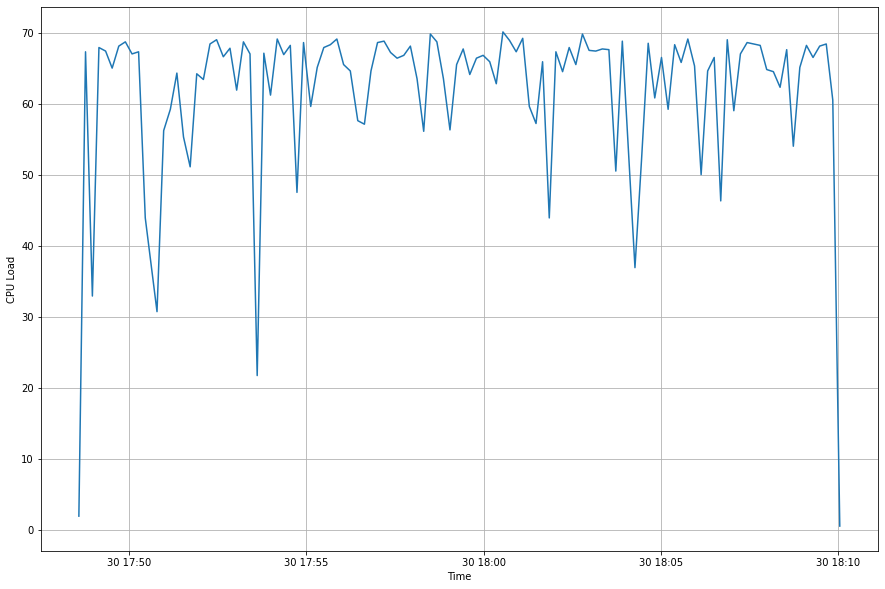

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

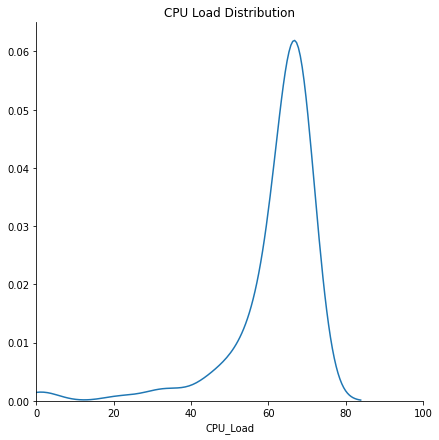

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

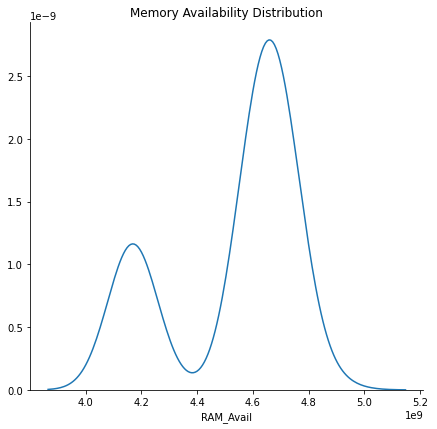

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-05-30 17:48:36.603235,502031600,1.0,0.875000,0.933333,"[0.7788707204905467, 0.856114272442225, 0.8571...",7,0,1,8,"[(788.0, 192.0, 855.0, 283.0), (178.0, 146.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-05-30 17:48:36.944735,334629500,0.0,0.000000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-05-30 17:48:37.287738,334979000,1.0,1.000000,1.000000,"[0.8003018108651911, 0.740495867768595]",2,0,0,2,"[(461.0, 41.0, 498.0, 88.0), (553.0, 115.0, 60...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-05-30 17:48:37.739737,334758300,1.0,0.225806,0.368421,"[0.7471819645732689, 0.6402116402116402, 0.731...",14,0,48,62,"[(288.0, 436.0, 319.0, 468.0), (259.0, 500.0, ...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-05-30 17:48:38.085235,326279100,1.0,1.000000,1.000000,"[0.8104374520337683, 0.7985791893021312, 0.816...",8,0,0,8,"[(789.0, 61.0, 833.0, 117.0), (494.0, 84.0, 53...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-05-30 18:09:51.039610,331370500,1.0,1.000000,1.000000,[0.873341375150784],1,0,0,1,"[(452.0, 130.0, 584.0, 327.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-05-30 18:09:51.385611,335603900,1.0,1.000000,1.000000,"[0.8444463941042288, 0.767890248424175]",2,0,0,2,"[(713.0, 411.0, 796.0, 544.0), (330.0, 411.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-05-30 18:09:51.813108,336475900,1.0,1.000000,1.000000,"[0.8022284122562674, 0.8301886792452831, 0.892...",27,0,0,27,"[(919.0, 360.0, 954.0, 400.0), (521.0, 303.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-05-30 18:09:52.168610,332940400,1.0,1.000000,1.000000,"[0.7795603089720736, 0.8694652098907418, 0.847...",7,0,0,7,"[(856.0, 77.0, 897.0, 141.0), (579.0, 73.0, 61...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,3.359616e+08,0.914881,0.790694,0.824407,6.493800,0.765034,5.814941,12.308741
std,6.908246e+06,0.233903,0.306612,0.275806,16.783144,4.986490,28.331386,39.822258
min,3.257207e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.337845e+08,1.000000,0.625000,0.727273,1.000000,0.000000,0.000000,1.000000
50%,3.350290e+08,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,3.000000
75%,3.362797e+08,1.000000,1.000000,1.000000,6.000000,0.000000,2.000000,9.000000
max,5.020316e+08,1.000000,1.000000,1.000000,309.000000,145.000000,589.000000,709.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count    3226.000000
mean      335.961507
std         6.908210
min       325.720000
25%       333.780000
50%       335.030000
75%       336.280000
max       502.030000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,0.999995,True,True,True,1.000000,0.000025,1.000000,0.000025,1.000000,0.000025
1,0.999993,True,True,True,1.000000,0.000050,1.000000,0.000050,1.000000,0.000050
2,0.999991,True,True,False,1.000000,0.000076,1.000000,0.000076,0.666667,0.000050
3,0.999991,True,True,True,1.000000,0.000101,1.000000,0.000101,0.750000,0.000076
4,0.999991,True,True,True,1.000000,0.000126,1.000000,0.000126,0.800000,0.000101
...,...,...,...,...,...,...,...,...,...,...
23412,0.500107,False,False,False,0.907402,0.535031,0.790544,0.466128,0.378807,0.223355
23413,0.500092,True,False,False,0.907406,0.535056,0.790510,0.466128,0.378790,0.223355
23414,0.500066,True,False,False,0.907410,0.535081,0.790476,0.466128,0.378774,0.223355
23415,0.500064,True,True,False,0.907414,0.535106,0.790485,0.466153,0.378758,0.223355


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,0.999995,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,0.999993,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,0.999991,True,True,False,1.000000,0.000421,1.000000,0.000421,0.666667,0.000281
3,0.999991,True,True,True,1.000000,0.000561,1.000000,0.000561,0.750000,0.000421
4,0.999991,True,True,True,1.000000,0.000701,1.000000,0.000701,0.800000,0.000561
...,...,...,...,...,...,...,...,...,...,...
6355,0.503822,True,True,False,0.980334,0.874158,0.964443,0.859989,0.671020,0.598345
6356,0.503468,True,True,False,0.980337,0.874299,0.964449,0.860129,0.670914,0.598345
6357,0.502544,True,True,False,0.980340,0.874439,0.964454,0.860269,0.670808,0.598345
6358,0.500484,True,False,False,0.980343,0.874579,0.964303,0.860269,0.670703,0.598345


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

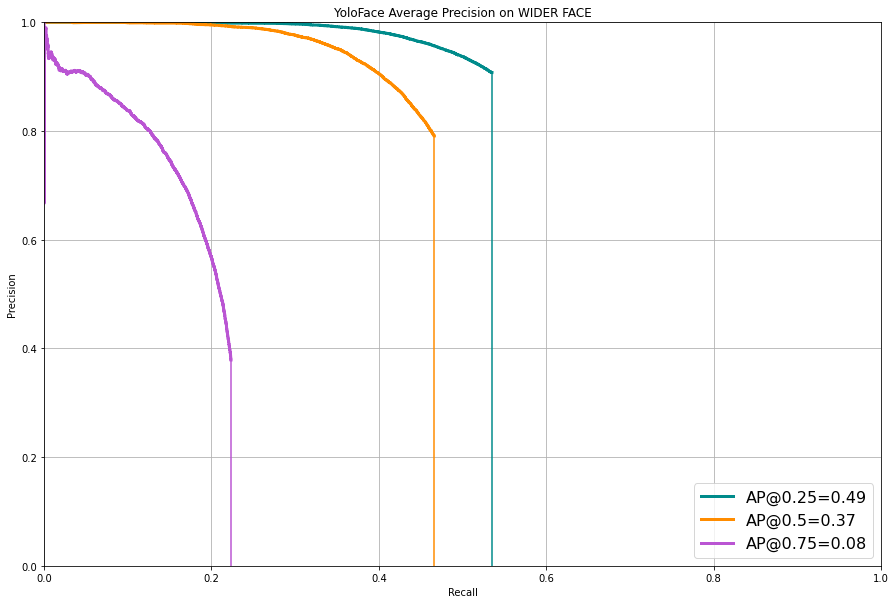

In [19]:
plot_pr(df_ap, 'YoloFace Average Precision on WIDER FACE')

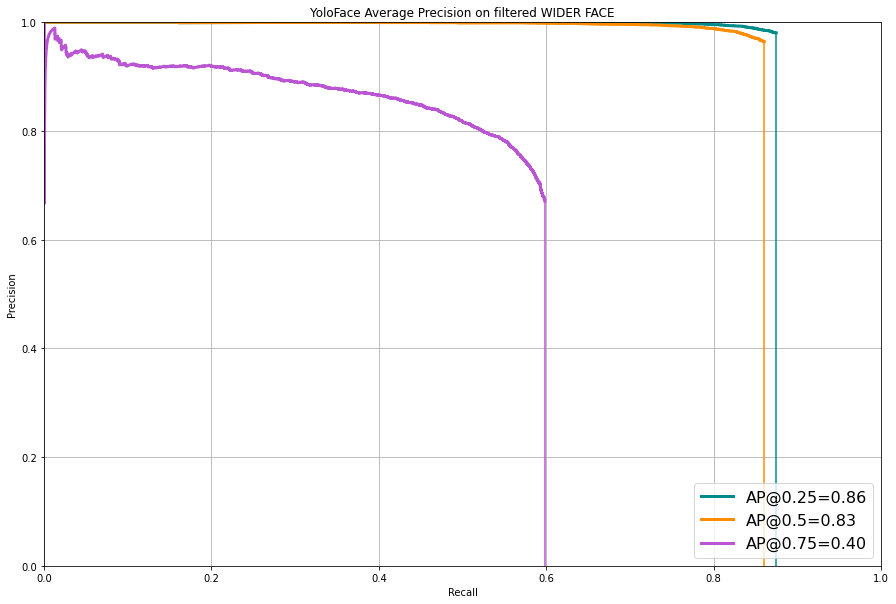

In [20]:
plot_pr(df_ap_filtered, 'YoloFace Average Precision on filtered WIDER FACE')

# YoloFace Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class YoloFaceDetector(Detector):
    IMG_WIDTH = 416
    IMG_HEIGHT = 416

    CONF_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    
    def __init__(self):
        model_cfg = '../src/yoloface/cfg/yolov3-face.cfg'
        model_weights = '../src/yoloface/model-weights/yolov3-wider_16000.weights'
        
        self.detector = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)
        self.detector.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        self.detector.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    
    def detect(self, image):
        blob = cv2.dnn.blobFromImage(image, 1 / 255, (self.IMG_WIDTH, self.IMG_HEIGHT),
                                     [0, 0, 0], 1, crop=False)
        self.detector.setInput(blob)
        outs = self.detector.forward(get_outputs_names(self.detector))

        boxes, confidence = post_process(image, outs, self.CONF_THRESHOLD, self.NMS_THRESHOLD)

        return boxes, confidence
    
yolo_face = YoloFaceDetector()

KeyboardInterrupt: 

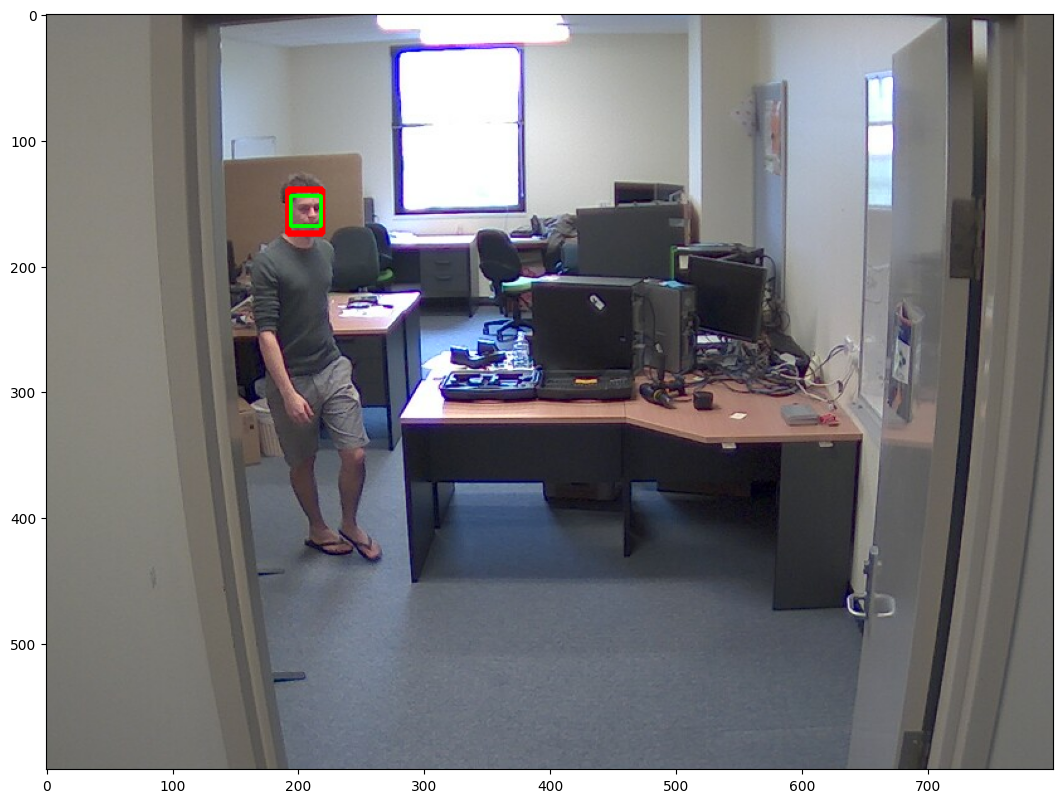

In [24]:
stt_aps, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=yolo_face,
    use_width_height=True,
    display_results=False,
    save_results="yoloface"
)

In [ ]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))